# Identifying Fraudulent Activities
__- Author: Fan Yuan__  
__- Date: 03/28/2019__

## Context:
E-commerce websites ofter transact huge amount of money. Where there's a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry

An e-commerce site selling hand-made clothes need a model to predict whether a user has a high probability of using the site to perform some illegal activity or not. Only have information about the user first transaction on the site and based on that make the classification ("fraud/ no fraud")

## Project goal:
* Build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent
    * For each user, will determine the country based on the numeric IP address
    * Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positive vs false negative would impact the model
* Explain the model from user perspective -- explain what kinds of users are more likely to be classified as at risk, what are their characteristics
* From a product perspective, explain how to use it, what kind of different user experience would be built based on the model output


## Data:

### Fraud_Data -- Columns:
* __user_id__: id of the user. Unique by user
* __signup_time__: the time when the user created her account (GMT time)
* __purchase_time__: the time when the user bought the item (GMT time)
* __purchase_value__: the cost of the item purchased (USD)
* __device_id__: the device id. You can assume that it is unique by device. i.e. 2 transactions with the same device ID means that the same physical device was used to buy
* __source__: user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser)
* __browser__: the browser used by the user
* __sex__: user sex: Male/ Female
* __age__: user age
* __ip_address__: user numeric ip address
* __class__: this is what we are trying to predict: whether the activity was fraudulent (1) or not (0)

### IpAddress_to_Country -- Columns:
___mapping each numeric ip address to its country. For each country, it gives a range. If the numeric ip address falls within the range, then the ap address belongs to the corresponding country___
* __lower_bound_ip_address__: the lower bound of the numeric ip address for that country
* __upper_bound_ip_address__: the upper bound of the numeric ip address for that country
* __country__: he corresponding country. If a user has an ip address whose value is within the upper and lower bound, then she is based in this country


In [51]:
# load required libraries
library(tidyverse)
library(randomForest)
library(ROCR)

# configure the graph size
# options(repr.plot.width=5, repr.plot.height=5)

In [26]:
# read in data
data <- read.csv('./Data/Fraud//Fraud_Data.csv')
ip_address <- read.csv('./Data/Fraud//IpAddress_to_Country.csv')

# check if there's duplicate rows in data
nrow(data) == length(unique(data$user_id))

[1] TRUE

In [27]:
# add the country to the user info dataset using the ip address
data_country <- rep(NA, nrow(data))
for (i in 1: nrow(data)){
    tmp = as.character(ip_address[data$ip_address[i] >= ip_address$lower_bound_ip_address 
                                  & data$ip_address[i] <= ip_address$upper_bound_ip_address,"country"])
    if (length(tmp) == 1){
        data_country[i] <- tmp
    }
}

# assign the country to original dataset
data$country <- data_country

# convert the date column to date format
data[,"signup_time"] <- as.POSIXct(data[, "signup_time"], tz = "GMT")
data[, "purchase_time"] <- as.POSIXct(data[, "purchase_time"], tz = "GMT")

# summarize the country
summary(as.factor(data$country))


United States                           China 
                          58049                           12038 
                          Japan                  United Kingdom 
                           7306                            4490 
              Korea Republic of                         Germany 
                           4162                            3646 
                         France                          Canada 
                           3161                            2975 
                         Brazil                           Italy 
                           2961                            1944 
                      Australia                     Netherlands 
                           1844                            1680 
             Russian Federation                           India 
                           1616                            1310 
Taiwan; Republic of China (ROC)                          Mexico 
                           1237                            1121 
                         Sweden                           Spain 
                           1090                            1027 
                   South Africa                     Switzerland 
                            838                             785 
                         Poland                       Argentina 
                            729                             661 
                      Indonesia                          Norway 
                            649                             609 
                       Colombia                          Turkey 
                            602                             568 
                       Viet Nam                         Romania 
                            550                             525 
                        Denmark                       Hong Kong 
                            490                             471 
                        Finland                         Austria 
                            460                             435 
                        Ukraine                           Chile 
                            429                             417 
                        Belgium      Iran (ISLAMIC Republic Of) 
                            409                             389 
                          Egypt                  Czech Republic 
                            359                             349 
                       Thailand                     New Zealand 
                            291                             278 
                         Israel                    Saudi Arabia 
                            272                             264 
                      Venezuela                         Ireland 
                            251                             240 
                 European Union                          Greece 
                            238                             231 
                       Portugal                         Hungary 
                            229                             211 
                       Malaysia                       Singapore 
                            210                             208 
                       Pakistan                     Philippines 
                            186                             177 
                       Bulgaria                         Morocco 
                            166                             158 
                        Algeria                            Peru 
                            122                             119 
                        Tunisia            United Arab Emirates 
                            118                             114 
                        Ecuador                       Lithuania 
                            106                              95 
                     Seychelles                           Kenya 
                             95                      

### Some idea for feature engineer:
- Time difference between sign-up time and purchase time
- If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
- If the ip address is unique. Many different users having the same ip address could be an indicator of fake accounts
- Week of the year and day of the week from time variable


In [28]:
# convert the date column to date format
data[,"signup_time"] <- as.POSIXct(data[, "signup_time"], tz = "GMT")
data[, "purchase_time"] <- as.POSIXct(data[, "purchase_time"], tz = "GMT")


In [29]:
# time difference between purchase and signup
data$purchase_signup_diff <- as.numeric(difftime(data$signup_time,data$purchase_time, unit = "secs"))

# check for each device id to see how many different users used it
data <- data %>% 
        group_by(device_id) %>%
        mutate(device_id_count = n())

# check for each ip address to see how many different users used it
data <- data %>% 
        group_by(ip_address) %>% 
        mutate(device_id_count = n())

# generate the day of the week
data$signup_time_wd <- format(data$signup_time, "%A")
data$purchase_time_wd <- format(data$purchase_timer, "%A")

# generate the week of the year
data$signup_time_wy <- as.numeric(format(data$signup_time, "%U"))
data$purchase_time_wy <- as.numeric(format(data$purchase_time, "%U"))

# drop the first 3 variables and device id
data_rf <- data[, -c(1:3, 5)]

Warning message:
“Unknown or uninitialised column: 'purchase_timer'.”

In [30]:
head(data_rf)

purchase_value,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_id_count,signup_time_wd,purchase_time_wd,signup_time_wy,purchase_time_wy
34,SEO,Chrome,M,39,732758369,0,Japan,-4506682,1,Tuesday,NULL,8,15
16,Ads,Chrome,F,53,350311388,0,United States,-17944,1,Sunday,NULL,23,23
15,SEO,Opera,M,53,2621473820,1,United States,-1,12,Thursday,NULL,0,0
44,SEO,Safari,M,41,3840542444,0,NA,-492085,1,Tuesday,NULL,17,18
39,Ads,Safari,M,45,415583117,0,United States,-4361461,1,Tuesday,NULL,29,36
42,Ads,Chrome,M,18,2809315200,0,Canada,-4240931,1,Thursday,NULL,20,27


In [31]:
# replace the NA in the country
data_rf$country[is.na(data_rf$country)] = "Not_found"

In [33]:
# only keep the top 50 countries, the others flaged as "Other"
data_rf$country <- ifelse(data_rf$country 
                          %in% names(sort(table(data_rf$country), decreasing = TRUE))[51: length(data_rf$country)]
                          ,"Other", as.character(data_rf$country))

In [34]:
head(data_rf)

purchase_value,source,browser,sex,age,ip_address,class,country,purchase_signup_diff,device_id_count,signup_time_wd,purchase_time_wd,signup_time_wy,purchase_time_wy
34,SEO,Chrome,M,39,732758369,0,Japan,-4506682,1,Tuesday,NULL,8,15
16,Ads,Chrome,F,53,350311388,0,United States,-17944,1,Sunday,NULL,23,23
15,SEO,Opera,M,53,2621473820,1,United States,-1,12,Thursday,NULL,0,0
44,SEO,Safari,M,41,3840542444,0,Not_found,-492085,1,Tuesday,NULL,17,18
39,Ads,Safari,M,45,415583117,0,United States,-4361461,1,Tuesday,NULL,29,36
42,Ads,Chrome,M,18,2809315200,0,Canada,-4240931,1,Thursday,NULL,20,27


In [35]:
# make 'class' a factor
data_rf$class <- as.factor(data_rf$class)

In [37]:
# all characters become factors
data_rf[sapply(data_rf, is.character)] <- lapply(data_rf[sapply(data_rf, is.character)], as.factor)

In [38]:
# split the data into train/ test
train_sample <- sample(nrow(data_rf), size = nrow(data) * 0.66)
train_data <- data_rf[train_sample,]
test_data <- data_rf[-train_sample,]

In [39]:
# build the model
rf <- randomForest(y = train_data$class, x = train_data[, -7], 
                   ytest = test_data$class, xtest = test_data[, -7], 
                   ntree = 50, mtry = 3, keep.forest = TRUE)
rf


Call:
 randomForest(x = train_data[, -7], y = train_data$class, xtest = test_data[,      -7], ytest = test_data$class, ntree = 50, mtry = 3, keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 50
No. of variables tried at each split: 3

        OOB estimate of  error rate: 4.37%
Confusion matrix:
      0    1  class.error
0 90387    3 3.318951e-05
1  4359 4984 4.665525e-01
                Test set error rate: 4.27%
Confusion matrix:
      0    1 class.error
0 46571    0   0.0000000
1  2192 2616   0.4559068

In [40]:
# to compare the false positive and false negative, generate the ROC plot
# combine the predicted data and actual values
rf_results <- data.frame(true_values = test_data$class, 
                         predictions = rf$test$votes[, 2])

# we can double check that with a 0.5 cut-off we get the same results shown 
# by rf output (since randomforest internally uses 0.5)
identical(as.numeric(as.character(rf$test$predicted)), ifelse(rf_results$predictions > 0.5, 1, 0))

[1] TRUE

numeric(0)

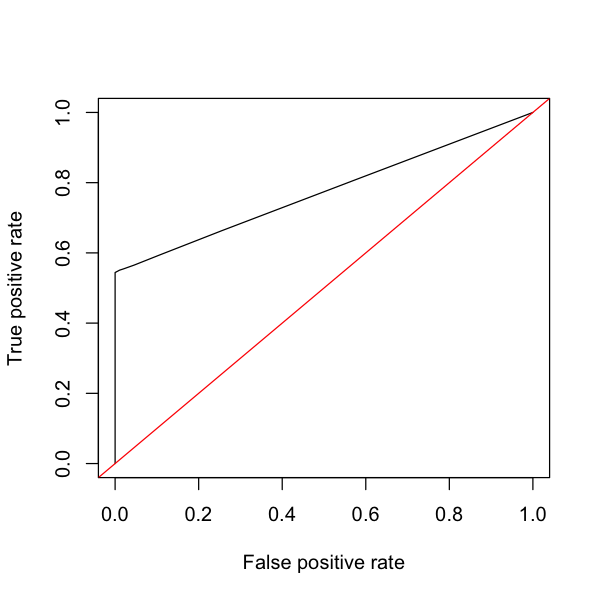

In [53]:
pred <- prediction(rf_results$predictions, rf_results$true_values)

# plot the ROC and look at true positive vs false positive
perf <- performance(pred, measure = 'tpr', x.measure = "fpr")
plot(perf) + abline(a = 0, b = 1, col = 'red')

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero. However, if we care about maximizing true positive, we will have to decrease the cut-off. This way, we will classify more events as “1” although some of them will be false

Based on the model that assigns to each user a probability of commiting a fraud. We can create different experience:
For example:
1. If predicted fraud probablity < X, the user has the normal experience (the high majority should fall here)
2. If X <= predicted < Z (so the user is at risk, but not too much), create an additional verification step, like verify your phone number via a code sent by SMS or log in via Facebook
3. If predicted fraud probability >= Z (so here is really likely the user is trying to commit a fraud), tell the user his session has peen put on hold, send this user info to someone who reviews it manually and either blocks the user or decides it is not a fraud s the session is resumed